In [25]:
import numpy as np
import math
import py
import torch
import torch.nn as nn
from mynn import *
from mydata import *

def FuncData(func, a_min=0.0, a_max=1.0, n_a = 50, x_min=0.0, x_max=1.0, n_x = 50):
    ''' g = g(a,x)
    '''
    X = np.linspace(x_min, x_max, n_x)
    params = np.reshape(np.linspace(a_min, a_max, n_a), (n_a,1))
    data = np.zeros((n_a, n_x))
    for i in range(n_a):
        for j in range(n_x):
            data[i, j] = func(params[i, 0], X[j])
    return params, X, data
    



In [26]:
# generate data 
def mysin(a, x):
    return np.sin(20*(a+x))
params, X, data = FuncData(mysin)
X_data, y_data = preprocess(params, 1, X, data)



# Vs = np.zeros((M, d))
# for i in range( M):
#     Vs[i, :] = i+1, i+1
M = 10
d = 2
np.random.seed(42)    
Vs = np.random.normal(0, 10, (M, d))

X_data  = EnrichData(X_data, Vs)

X_train = torch.from_numpy(X_data[0::2,:].astype(np.float32))
X_test  = torch.from_numpy(X_data[1::2,:].astype(np.float32))
y_train = torch.from_numpy(y_data[0::2,:].astype(np.float32))
y_test  = torch.from_numpy(y_data[1::2,:].astype(np.float32))



In [27]:
X_train.shape

torch.Size([1250, 22])

# DeepONet

In [11]:
# training with adam
branch_dim = 2*M+1 
trunk_dim = 1

branch_depth=3
trunk_depth=3

width=50
activation='relu'
model = DeepONet(branch_dim, trunk_dim, branch_depth, trunk_depth, width,
                 activation)

loss_fn = torch.nn.MSELoss(reduction='mean')


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
for t in range(50000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(X_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train)
    if t % 1000 == 0:
        loss_test = loss_fn(model(X_test), y_test)
        print('{:<9}Train loss: {:<25}Test loss: {:<25}'.format(t, loss.item(), loss_test.item()), flush=True)


    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()


0        Train loss: 0.5087617039680481       Test loss: 0.510430097579956        
1000     Train loss: 0.3874950408935547       Test loss: 0.3933956027030945       
2000     Train loss: 0.24658937752246857      Test loss: 0.2597465217113495       
3000     Train loss: 0.16034993529319763      Test loss: 0.1773199886083603       
4000     Train loss: 0.15965057909488678      Test loss: 0.1829511672258377       
5000     Train loss: 0.07993640005588531      Test loss: 0.0974498987197876       
6000     Train loss: 0.037226155400276184     Test loss: 0.04694453999400139      
7000     Train loss: 0.0237104631960392       Test loss: 0.032153625041246414     
8000     Train loss: 0.016071636229753494     Test loss: 0.024171918630599976     


KeyboardInterrupt: 

In [22]:
y_pred = model.predict(X_test, True)

0.5922735

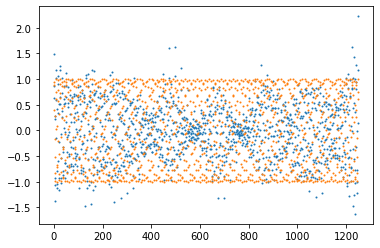

In [23]:
plt.plot(y_pred, "o", markersize=1)
plt.plot(y_test.cpu().detach().numpy(), "o", markersize=1)

print("DeepONet error: ", np.linalg.norm(y_pred - y_test.cpu().detach().numpy())/np.linalg.norm(y_test.cpu().detach().numpy()))

# DeepONet+

In [26]:
# training with adam
branch_dim = 2*M+1 
trunk_dim = 2*M+2

branch_depth=3
trunk_depth=3

width=50
activation='relu'
model = DeepONet(branch_dim, trunk_dim, branch_depth, trunk_depth, width,
                 activation)

loss_fn = torch.nn.MSELoss(reduction='mean')


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
for t in range(50000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(X_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train)
    if t % 1000 == 0:
        loss_test = loss_fn(model(X_test), y_test)
        print('{:<9}Train loss: {:<25}Test loss: {:<25}'.format(t, loss.item(), loss_test.item()), flush=True)


    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()



0        Train loss: 0.6484006643295288       Test loss: 0.657701849937439        
1000     Train loss: 0.14433322846889496      Test loss: 0.1490953117609024       
2000     Train loss: 0.07873210310935974      Test loss: 0.08206199109554291      
3000     Train loss: 0.0520663745701313       Test loss: 0.05439788103103638      
4000     Train loss: 0.048344116657972336     Test loss: 0.050020888447761536     
5000     Train loss: 0.017689017578959465     Test loss: 0.018690306693315506     
6000     Train loss: 0.0121415164321661       Test loss: 0.012926065362989902     
7000     Train loss: 0.009481477551162243     Test loss: 0.010173613205552101     
8000     Train loss: 0.007352400105446577     Test loss: 0.008020512759685516     
9000     Train loss: 0.06354701519012451      Test loss: 0.06517411023378372      
10000    Train loss: 0.006451582536101341     Test loss: 0.007084221579134464     
11000    Train loss: 0.005581765901297331     Test loss: 0.006221531890332699     
1200

0.32757372

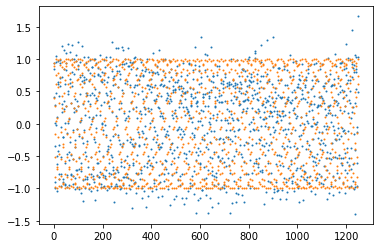

In [25]:
y_pred = model.predict(X_test, True)
plt.plot(y_pred, "o", markersize=1)
plt.plot(y_test.cpu().detach().numpy(), "o", markersize=1)
print("DeepOnet+: ", np.linalg.norm(y_pred - y_test.cpu().detach().numpy())/np.linalg.norm(y_test.cpu().detach().numpy()))

# DeepONet++

In [ ]:
# training with adam
branch_dim = 2*M+2 
trunk_dim = 2*M+2 

branch_depth=3
trunk_depth=3

width=50
activation='relu'
model = DeepONet(branch_dim, trunk_dim, branch_depth, trunk_depth, width,
                 activation)

loss_fn = torch.nn.MSELoss(reduction='mean')


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
for t in range(50000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(X_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train)
    if t % 1000 == 0:
        loss_test = loss_fn(model(X_test), y_test)
        print('{:<9}Train loss: {:<25}Test loss: {:<25}'.format(t, loss.item(), loss_test.item()), flush=True)


    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()




In [ ]:
y_pred = model.predict(X_test, True)
plt.plot(y_pred, "o", markersize=1)
plt.plot(y_test.cpu().detach().numpy(), "o", markersize=1)
print("DeepOnet+: ", np.linalg.norm(y_pred - y_test.cpu().detach().numpy())/np.linalg.norm(y_test.cpu().detach().numpy()))

# FNN

In [22]:
# training with adam
ind = X_data.shape[1] 
outd = 1
layers=4
width=50
activation='relu'

model = FNN(ind, outd, layers, width, activation)
loss_fn = torch.nn.MSELoss(reduction='mean')

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
for t in range(50000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(X_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train)
    if t % 1000 == 0:
        loss_test = loss_fn(model(X_test), y_test)
        print('{:<9}Train loss: {:<25}Test loss: {:<25}'.format(t, loss.item(), loss_test.item()), flush=True)


    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()




0        Train loss: 0.5031487345695496       Test loss: 0.5040737986564636       
1000     Train loss: 0.00010841317271115258   Test loss: 0.001726645859889686     
2000     Train loss: 6.845377356512472e-05    Test loss: 0.0015893005765974522    
3000     Train loss: 0.00013209671305958182   Test loss: 0.001624315045773983     
4000     Train loss: 1.9335262550157495e-05   Test loss: 0.0014736156444996595    
5000     Train loss: 1.6203277482418343e-05   Test loss: 0.0014303501229733229    
6000     Train loss: 2.7522375603439286e-05   Test loss: 0.0014266807120293379    


KeyboardInterrupt: 

FNN error:  0.053389885


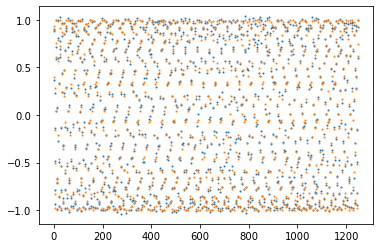

In [23]:
y_pred = model.predict(X_test, True)
plt.plot(y_pred, "o", markersize=1)
plt.plot(y_test.cpu().detach().numpy(), "o", markersize=1)

print("FNN error: ", np.linalg.norm(y_pred - y_test.cpu().detach().numpy())/np.linalg.norm(y_test.cpu().detach().numpy()))

FNN error:  0.0019257955551147462
FNN error:  0.09624767


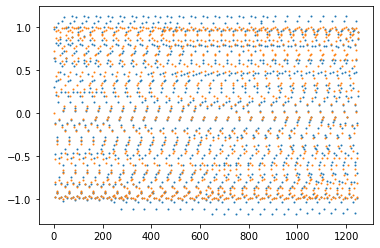

In [20]:
y_pred_train = model.predict(X_train, True)
plt.plot(y_pred_train, "o", markersize=1)
plt.plot(y_train.cpu().detach().numpy(), "o", markersize=1)

print("FNN error: ", np.linalg.norm(y_pred_train - y_train.cpu().detach().numpy())/1250)
print("FNN error: ", np.linalg.norm(y_pred_train - y_train.cpu().detach().numpy())/np.linalg.norm(y_train.cpu().detach().numpy()))

In [19]:
y_pred_train.shape

(1250, 1)

# PCA

In [48]:
# params, X, data = FuncData(mysin)
bases, X_train, y_train, X_test, y_test = preprocess_PCA(params, data, 0.999)



M = 10
d = 1
np.random.seed(42)    
Vs = np.random.normal(0, 10, (M, d))
X_train  = EnrichData(X_train, Vs)
X_test  = EnrichData(X_test, Vs)


X_train = torch.from_numpy(X_train.astype(np.float32))
X_test  = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test  = torch.from_numpy(y_test.astype(np.float32))



In [49]:
X_train.shape

torch.Size([25, 21])

In [50]:

# training with adam
ind = X_train.shape[1]
outd = y_train.shape[1]
layers=3
width=50
activation='relu'

model = FNN(ind, outd, layers, width, activation)
loss_fn = torch.nn.MSELoss(reduction='mean')

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
for t in range(10000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(X_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train)
    if t % 1000 == 0:
        loss_test = loss_fn(model(X_test), y_test)
        print('{:<9}Train loss: {:<25}Test loss: {:<25}'.format(t, loss.item(), loss_test.item()), flush=True)


    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()






0        Train loss: 12.4489164352417         Test loss: 12.479143142700195       
1000     Train loss: 1.9191456885891967e-06   Test loss: 0.03676920756697655      
2000     Train loss: 3.2583190545665275e-07   Test loss: 0.038114748895168304     
3000     Train loss: 1.5686555343563668e-06   Test loss: 0.03952014073729515      
4000     Train loss: 1.8552733308752067e-05   Test loss: 0.04106181487441063      
5000     Train loss: 9.388731996295974e-06    Test loss: 0.04271864518523216      
6000     Train loss: 9.40606878430117e-06     Test loss: 0.04218257591128349      
7000     Train loss: 0.00017065661086235195   Test loss: 0.042852118611335754     
8000     Train loss: 3.6695055314339697e-06   Test loss: 0.042423687875270844     
9000     Train loss: 1.8274045032740105e-06   Test loss: 0.04232490062713623      


PCA:  0.05792483816362804


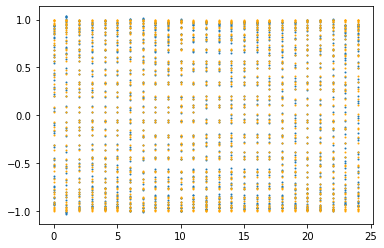

In [51]:
y_pred = model.predict(X_test, True)
y_pred_full = np.dot(y_pred, bases.T)
y_test_full = data[1::2,:] #np.dot(bases, y_test.cpu().detach().numpy().T)
plt.plot(y_pred_full, "o", color="C0", markersize=1)
plt.plot(y_test_full, "o", color="orange", markersize=1)

print("PCA: ", np.linalg.norm(y_pred_full - y_test_full)/np.linalg.norm(y_test_full))

In [20]:
outd

2